In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
from scipy import sparse

In [2]:
# Common Varibles
random_state=42
cv=5
scoring='roc_auc'
verbose=2

I'll be performing classification models on raw data and on OHE.

In [3]:
train_data=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
test_data=test.drop(columns=['id'],axis=1)

In [4]:
y_true=train_data['ACTION']
train_data=train_data.drop(['ACTION'],axis=1)
train_data.shape,y_true.shape

((32769, 9), (32769,))

In [5]:
#splitting the dataset
from sklearn.model_selection import train_test_split
# Split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(train_data,y_true, test_size=0.2,random_state=100)
x_train.shape,x_test.shape

((26215, 9), (6554, 9))

KNN classifier

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay

In [7]:
knn = KNeighborsClassifier(n_jobs=-1)
from sklearn.model_selection import RandomizedSearchCV
k_range=np.arange(1,100,5)
param_grid=dict(n_neighbors=k_range)
grid=RandomizedSearchCV(knn,param_grid,cv=cv,random_state=random_state,scoring=scoring,verbose=verbose)
grid_serch=grid.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ......................................n_neighbors=1; total time=   3.0s
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END .....................................n_neighbors=86; total time=   0.1s
[CV] END .....................................n_neighbors=86; total time=   0.1s
[CV] END .....................................n_neighbors=86; total time=   0.1s
[CV] END .....................................n_neighbors=86; total time=   0.1s
[CV] END .....................................n_neighbors=86; total time=   0.1s
[CV] END .....................................n_neighbors=76; total time=   0.1s
[CV] END .....................................n_

In [8]:
grid_serch.best_params_

{'n_neighbors': 26}

In [9]:
y_pred=grid.predict(x_test)
test_acc_knn=accuracy_score(y_test,y_pred)*100
test_acc_knn
# knn=KNeighborsClassifier(n_neighbors=8)
# knn.fit(x_train, y_train)
# y_pred=knn.predict(x_test)
# test_acc=accuracy_score(y_test,y_pred)*100
# test_acc

94.3240768996033

In [10]:
from sklearn.metrics import roc_auc_score
auc_knn = roc_auc_score(y_test,y_pred)
auc_knn

0.5013404825737265

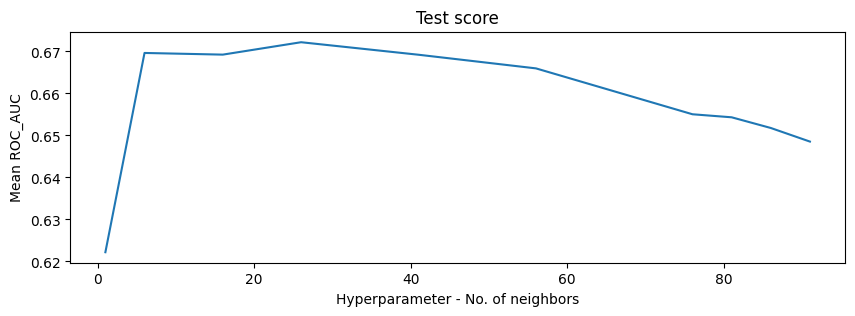

In [11]:
results=pd.DataFrame.from_dict(grid_serch.cv_results_)
results=results.sort_values('param_n_neighbors')
plt.figure(figsize=(10,3))
plt.plot(results['param_n_neighbors'],results['mean_test_score']);
plt.grid();
plt.xlabel('Hyperparameter - No. of neighbors');
plt.ylabel('Mean ROC_AUC');
plt.title('Test score'); 
plt.grid();

In [12]:
best_c=grid_serch.best_params_['n_neighbors']
best_c

26

In [13]:
model=KNeighborsClassifier(n_neighbors=best_c,n_jobs=-1)
model.fit(train_data,y_true)

KNeighborsClassifier(n_jobs=-1, n_neighbors=26)

In [14]:
prediction=model.predict_proba(test_data)[:,1]

In [15]:
submit = pd.DataFrame()
submit["Id"] = test["id"]
submit["ACTION"] = prediction
submit.to_csv("knn.csv", index = False)

In [16]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=grid.classes_)
# y_test.shape,y_pred.shape

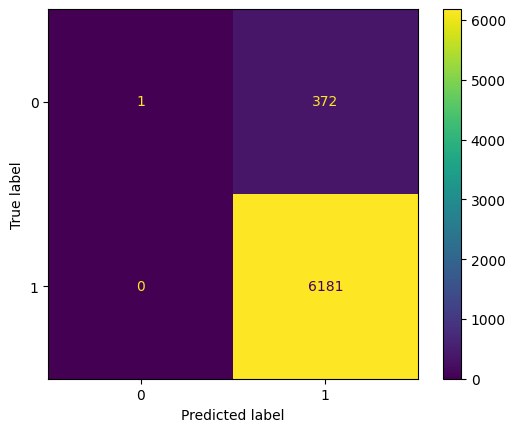

In [17]:
disp.plot()
plt.show()

KNN OHE

In [18]:
from scipy import sparse
train_ohe=sparse.load_npz('train_ohe.npz')
test_ohe=sparse.load_npz('test_ohe.npz')
train_ohe.shape,test_ohe.shape

((32769, 4500), (912363, 4500))

In [19]:
from sklearn.model_selection import GridSearchCV
parameters={'n_neighbors':np.arange(1,100,5)}
clf=RandomizedSearchCV(KNeighborsClassifier(),parameters,cv=cv,verbose=verbose,scoring=scoring,n_jobs=4)
# grid=RandomizedSearchCV(knn,param_grid,cv=cv,random_state=random_state,scoring=scoring,verbose=verbose)
best_model=clf.fit(train_ohe,y_true)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [20]:
result=pd.DataFrame.from_dict(best_model.cv_results_)
result=result.sort_values('param_n_neighbors')
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.023248,0.008628,17.500311,4.762195,1,{'n_neighbors': 1},0.622648,0.627625,0.609351,0.623683,0.638444,0.624350,0.009356,10
5,0.019254,0.011588,21.835885,6.743667,6,{'n_neighbors': 6},0.760056,0.794993,0.767923,0.750457,0.784015,0.771489,0.016094,9
0,0.008974,0.001991,52.705842,14.845786,16,{'n_neighbors': 16},0.801253,0.819555,0.808495,0.782627,0.820162,0.806418,0.013846,3
4,0.018360,0.003916,42.821361,9.809678,21,{'n_neighbors': 21},0.810937,0.828446,0.803845,0.782430,0.824108,0.809953,0.016359,1
9,0.014559,0.004660,19.407526,3.974220,26,{'n_neighbors': 26},0.808716,0.822521,0.805768,0.774925,0.821470,0.806680,0.017222,2
8,0.019652,0.010203,17.410857,6.894409,31,{'n_neighbors': 31},0.807146,0.822594,0.804889,0.772999,0.816963,0.804918,0.017212,4
7,0.016857,0.007513,34.966527,10.699681,46,{'n_neighbors': 46},0.804339,0.818778,0.797889,0.765292,0.807178,0.798695,0.018020,5
1,0.028726,0.029645,30.261013,10.096165,56,{'n_neighbors': 56},0.799555,0.815050,0.791929,0.769536,0.802458,0.795706,0.015058,7
2,0.033517,0.032262,30.480091,4.871167,61,{'n_neighbors': 61},0.799612,0.817452,0.791250,0.769539,0.804519,0.796474,0.015921,6
6,0.012270,0.002632,29.670074,9.244436,76,{'n_neighbors': 76},0.796652,0.814884,0.785648,0.765380,0.799800,0.792473,0.016456,8


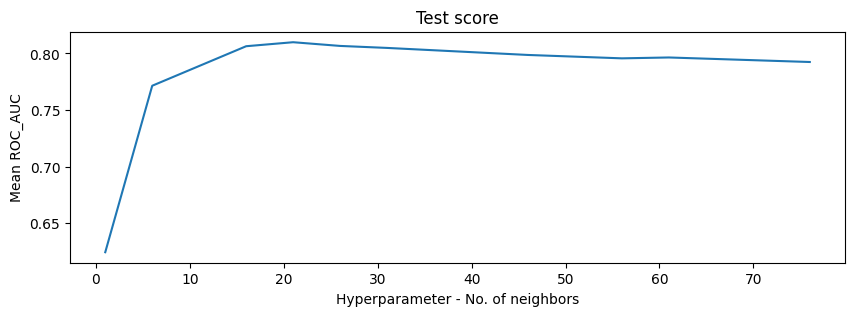

In [21]:
plt.figure(figsize=(10,3))
plt.plot(result['param_n_neighbors'],result['mean_test_score']);
plt.grid();
plt.xlabel('Hyperparameter - No. of neighbors');
plt.ylabel('Mean ROC_AUC');
plt.title('Test score'); 
plt.grid();

In [22]:
best_c=best_model.best_params_['n_neighbors']
best_c

21

In [23]:
model=KNeighborsClassifier(n_neighbors=best_c,n_jobs=-1)
model.fit(train_ohe,y_true)

KNeighborsClassifier(n_jobs=-1, n_neighbors=21)

In [24]:
# prediction=model.predict_proba(test_ohe)[:,1]

In [25]:
y_pred=model.predict(train_ohe)
test_acc_knn_ohe=accuracy_score(y_true,y_pred)*100
test_acc_knn_ohe

94.51921022918002

In [26]:
# submit = pd.read_csv('knn.csv')
# # submit["Id"] = test["id"]
# submit["ACTION_KNN_OHE"] = prediction
# submit.to_csv("knn.csv", index = False)

In [27]:
from sklearn.metrics import roc_auc_score
auc_knn_ohe = roc_auc_score(y_true, y_pred)
auc_knn_ohe

0.5417110481723779

In [28]:
from prettytable import PrettyTable
x = PrettyTable(['Model', 'Feature', 'Accuracy', 'ROC_AUC'])
x.add_row(['KNeighborsClassifier', '-', round(test_acc_knn,5), round(auc_knn,5)])
x.add_row(['KNeighborsClassifier','ohe', round(test_acc_knn_ohe,5), round(auc_knn_ohe,6)])
print(x)

+----------------------+---------+----------+----------+
|        Model         | Feature | Accuracy | ROC_AUC  |
+----------------------+---------+----------+----------+
| KNeighborsClassifier |    -    | 94.32408 | 0.50134  |
| KNeighborsClassifier |   ohe   | 94.51921 | 0.541711 |
+----------------------+---------+----------+----------+


Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform

In [30]:
C_val = uniform(loc=0, scale=4)
lr=LogisticRegression(verbose=verbose,random_state=random_state,class_weight='balanced',max_iter=500,n_jobs=-1)
parameters={'C':C_val}
clf=RandomizedSearchCV(lr,parameters,verbose=verbose,cv=cv,random_state=random_state,scoring=scoring,n_iter=100,n_jobs=-1)
best_model=clf.fit(x_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [31]:
best_c=best_model.best_params_['C']
best_c

0.08233797718320979

In [32]:
result=pd.DataFrame.from_dict(best_model.cv_results_)
result.sort_values('param_C')
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.390084,0.054491,0.009279,0.000747,1.49816,{'C': 1.49816047538945},0.529549,0.542286,0.500633,0.511880,0.550482,0.526966,0.018522,57
1,0.371934,0.052047,0.009677,0.000872,3.802857,{'C': 3.8028572256396647},0.529549,0.542296,0.500632,0.511880,0.550482,0.526968,0.018524,11
2,0.356145,0.070152,0.009178,0.001161,2.927976,{'C': 2.9279757672456204},0.529549,0.542296,0.500631,0.511880,0.550482,0.526968,0.018525,30
3,0.367901,0.050178,0.008481,0.000638,2.394634,{'C': 2.3946339367881464},0.529549,0.542284,0.500631,0.511880,0.550482,0.526965,0.018523,87
4,0.403811,0.037511,0.008884,0.001067,0.624075,{'C': 0.6240745617697461},0.529549,0.542293,0.500631,0.511880,0.550482,0.526967,0.018524,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.413595,0.055653,0.008980,0.000629,1.975182,{'C': 1.975182385457563},0.529549,0.542284,0.500632,0.511880,0.550482,0.526966,0.018522,77
96,0.400932,0.049216,0.008977,0.000633,2.090931,{'C': 2.0909313175279762},0.529549,0.542285,0.500632,0.511880,0.550482,0.526966,0.018522,70
97,0.391743,0.065073,0.008779,0.000743,1.710164,{'C': 1.7101640734341985},0.529549,0.542286,0.500632,0.511880,0.550482,0.526966,0.018523,57
98,0.376189,0.051042,0.007977,0.000631,0.101677,{'C': 0.10167650697638075},0.529549,0.542257,0.500660,0.511879,0.550482,0.526965,0.018510,87


In [33]:
model=LogisticRegression(C=best_c,verbose=verbose,random_state=random_state,class_weight='balanced',n_jobs=-1)
model.fit(train_data,y_true)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


LogisticRegression(C=0.08233797718320979, class_weight='balanced', n_jobs=-1,
                   random_state=42, verbose=2)

In [34]:
y_pred=model.predict(x_test)
test_acc_lr=accuracy_score(y_test,y_pred)*100
auc_lr = roc_auc_score(y_test,y_pred)
test_acc_lr,auc_lr

(50.15257857796765, 0.5304092841810044)

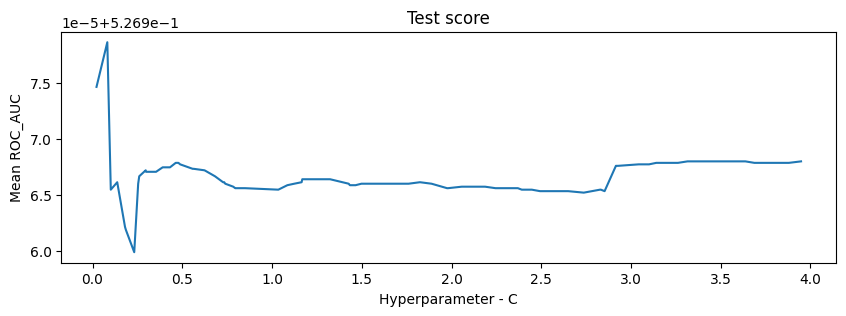

In [35]:
results=pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_C')
plt.figure(figsize=(10,3))
plt.plot(results['param_C'],results['mean_test_score']);
plt.grid();
plt.xlabel('Hyperparameter - C');
plt.ylabel('Mean ROC_AUC');
plt.title('Test score'); 
plt.grid();

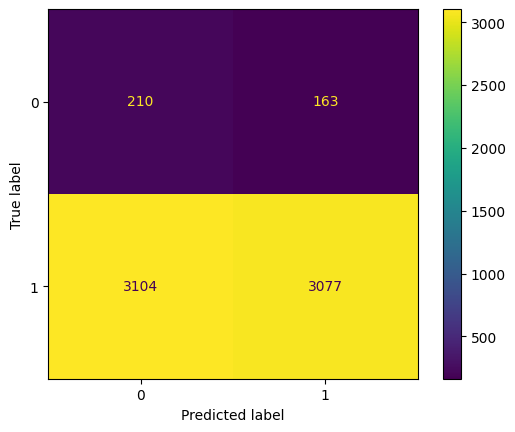

In [36]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=best_model.classes_)
disp.plot()
plt.show()

Logistic Regression OHE

In [37]:
train_ohe.shape,test_ohe.shape,y_true.shape

((32769, 4500), (912363, 4500), (32769,))

In [38]:
C_val = uniform(loc=0, scale=4)
lr=LogisticRegression(verbose=verbose,random_state=random_state,class_weight='balanced',max_iter=500,n_jobs=-1)
parameters={'C':C_val}
clf=RandomizedSearchCV(lr,parameters,verbose=verbose,cv=cv,random_state=random_state,scoring=scoring,n_iter=100,n_jobs=-1)
best_model=clf.fit(train_ohe,y_true)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


In [39]:
best_c=best_model.best_params_['C']
best_c

0.7948627261366896

In [40]:
result=pd.DataFrame.from_dict(best_model.cv_results_)
result=result.sort_values('param_C')
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
72,0.352753,0.014872,0.006287,4.018605e-04,0.022088,{'C': 0.022088468494409597},0.827415,0.833777,0.808035,0.814502,0.841708,0.825087,0.012329,100
10,0.524847,0.045535,0.006286,4.033454e-04,0.082338,{'C': 0.08233797718320979},0.864374,0.867161,0.845380,0.846580,0.866256,0.857950,0.009822,99
98,0.616713,0.102582,0.005984,6.310533e-04,0.101677,{'C': 0.10167650697638075},0.868155,0.870643,0.849562,0.850073,0.868926,0.861472,0.009551,98
42,0.714311,0.065119,0.006686,6.048834e-04,0.137554,{'C': 0.13755408446087358},0.872632,0.874930,0.855066,0.854638,0.872126,0.865878,0.009053,97
58,0.744951,0.054407,0.006384,4.875291e-04,0.180909,{'C': 0.18090915564215226},0.875813,0.877965,0.859005,0.857691,0.874480,0.868991,0.008771,96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,2.083155,0.093795,0.005985,2.847481e-06,3.802857,{'C': 3.8028572256396647},0.877215,0.881082,0.863760,0.853882,0.876353,0.870458,0.010128,90
34,2.075838,0.047907,0.006383,4.882875e-04,3.862528,{'C': 3.8625281322982374},0.877135,0.880991,0.863656,0.853775,0.876278,0.870367,0.010138,91
50,1.989772,0.077718,0.005985,3.044298e-06,3.878339,{'C': 3.8783385110582342},0.877105,0.880956,0.863630,0.853730,0.876245,0.870333,0.010142,92
11,1.972316,0.061865,0.006185,3.980222e-04,3.879639,{'C': 3.8796394086479773},0.877091,0.880962,0.863608,0.853724,0.876251,0.870327,0.010146,93


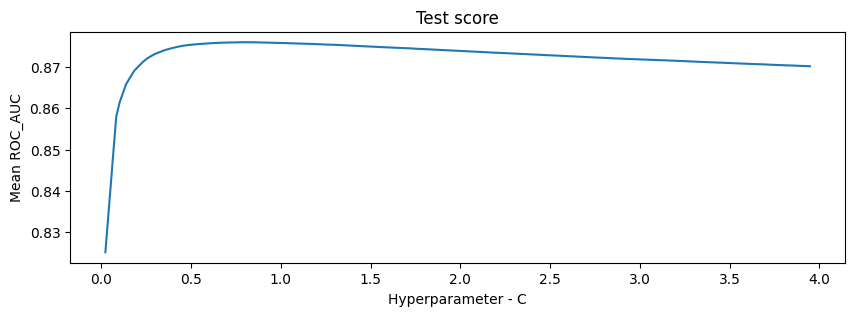

In [41]:
plt.figure(figsize=(10,3))
plt.plot(result['param_C'],result['mean_test_score']);
plt.grid();
plt.xlabel('Hyperparameter - C');
plt.ylabel('Mean ROC_AUC');
plt.title('Test score'); 
plt.grid();

In [42]:
model=LogisticRegression(C=best_c,verbose=verbose,random_state=random_state,class_weight='balanced',n_jobs=-1)
model.fit(train_ohe,y_true)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


LogisticRegression(C=0.7948627261366896, class_weight='balanced', n_jobs=-1,
                   random_state=42, verbose=2)

In [43]:
y_pred=model.predict(train_ohe)
test_acc_lr_ohe=accuracy_score(y_true,y_pred)*100
auc_lr_ohe = roc_auc_score(y_true, y_pred)
test_acc_lr_ohe,auc_lr_ohe

(91.88562360767799, 0.9413502628159217)

In [44]:
from prettytable import PrettyTable
x = PrettyTable(['Model', 'Feature', 'Accuracy', 'ROC_AUC'])
x.add_row(['Logistic Regression', '-', round(test_acc_knn,5), round(auc_lr,5)])
x.add_row(['Logistic Regression','ohe', round(test_acc_lr_ohe,5), round(auc_lr_ohe,5)])
print(x)

+---------------------+---------+----------+---------+
|        Model        | Feature | Accuracy | ROC_AUC |
+---------------------+---------+----------+---------+
| Logistic Regression |    -    | 94.32408 | 0.53041 |
| Logistic Regression |   ohe   | 91.88562 | 0.94135 |
+---------------------+---------+----------+---------+


Decision Tree

In [45]:
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

In [46]:
param_dist = {"max_depth": [3, None],"max_features": randint(1, 9),"min_samples_leaf": randint(1, 9),"criterion": ["gini", "entropy"]}

In [47]:
tree = DecisionTreeClassifier()
clf=RandomizedSearchCV(tree, param_dist,verbose=verbose,cv=cv,random_state=random_state,scoring=scoring,n_iter=100,n_jobs=-1)
best_model=clf.fit(x_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [48]:
from sklearn.metrics import roc_auc_score

In [49]:
y_pred=best_model.predict(x_test)
test_acc_dt=accuracy_score(y_test,y_pred)*100
auc_dt = roc_auc_score(y_test,y_pred)
test_acc_dt,auc_dt

(93.59169972535855, 0.6234165671588059)

In [50]:
best_model.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 5,
 'min_samples_leaf': 8}

In [51]:
param_max_features=best_model.best_params_['max_features']
param_max_features

5

In [52]:
results=pd.DataFrame.from_dict(best_model.cv_results_)
# results=results.sort_values('param_n_neighbors')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.102243,0.006588,0.007582,0.002242,gini,None,5,7,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.766365,0.747188,0.732410,0.766250,0.746656,0.751774,0.012997,7
1,0.107630,0.005376,0.008380,0.001019,gini,None,5,5,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.767934,0.759649,0.730921,0.756596,0.740448,0.751110,0.013471,10
2,0.072837,0.005297,0.007580,0.001738,gini,None,3,7,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.743181,0.758564,0.722211,0.728149,0.746932,0.739808,0.013111,31
3,0.046304,0.003582,0.006383,0.000489,gini,3,8,5,"{'criterion': 'gini', 'max_depth': 3, 'max_fea...",0.616580,0.633491,0.571782,0.595403,0.605888,0.604629,0.020695,72
4,0.187122,0.010268,0.006086,0.000487,entropy,None,8,3,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.746945,0.757831,0.711482,0.737772,0.747022,0.740210,0.015707,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.102343,0.028301,0.005386,0.001352,entropy,None,4,5,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.741351,0.754013,0.745306,0.761808,0.745675,0.749631,0.007354,13
96,0.072716,0.009082,0.007587,0.000853,gini,None,3,7,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.752436,0.743699,0.737640,0.761323,0.769606,0.752941,0.011557,5
97,0.025335,0.009026,0.006583,0.000800,gini,3,3,3,"{'criterion': 'gini', 'max_depth': 3, 'max_fea...",0.537539,0.663255,0.594975,0.584188,0.595758,0.595143,0.040194,83
98,0.083294,0.001784,0.007980,0.003989,entropy,None,3,4,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.735790,0.740981,0.731983,0.760056,0.745850,0.742932,0.009761,23


In [53]:
results['param_max_features'].unique()

array([5, 3, 8, 2, 6, 1, 7, 4], dtype=object)

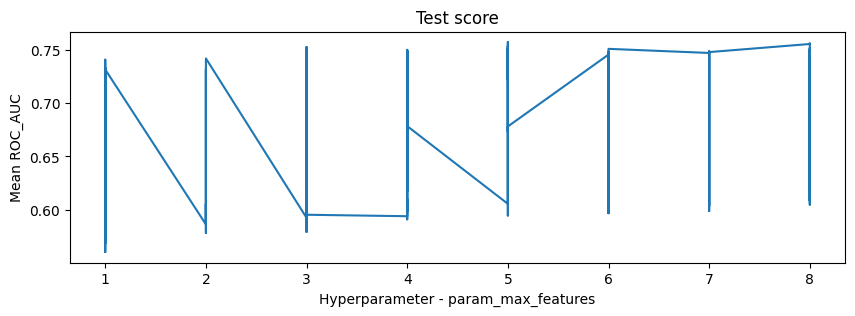

In [54]:
results=results.sort_values('param_max_features')
plt.figure(figsize=(10,3))
plt.plot(results['param_max_features'],results['mean_test_score']);
plt.grid();
plt.xlabel('Hyperparameter - param_max_features');
plt.ylabel('Mean ROC_AUC');
plt.title('Test score'); 
plt.grid();

In [55]:
model = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=6, max_features=7)
model.fit(train_data,y_true)

DecisionTreeClassifier(criterion='entropy', max_features=7, min_samples_leaf=6)

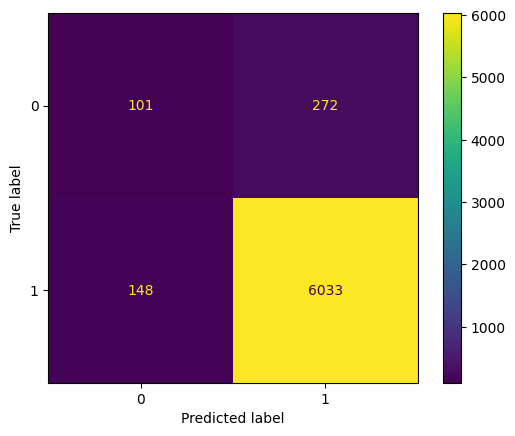

In [56]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()
plt.show()

Decision tree OHE

In [57]:
param_dist = {"max_depth": [3, None],"max_features": randint(1, 9),"min_samples_leaf": randint(1, 9),"criterion": ["gini", "entropy"]}
tree = DecisionTreeClassifier()
clf=RandomizedSearchCV(tree, param_dist,verbose=verbose,cv=cv,random_state=random_state,scoring=scoring,n_iter=100,n_jobs=-1)
best_model=clf.fit(train_ohe,y_true)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [58]:
results=pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_max_features')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
89,0.015262,0.008650,0.005386,0.000798,entropy,None,1,3,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.500324,0.500243,0.500486,0.502123,0.506183,0.501872,0.002263,84
71,0.022854,0.011419,0.006086,0.001679,entropy,3,1,5,"{'criterion': 'entropy', 'max_depth': 3, 'max_...",0.500022,0.507182,0.500567,0.501558,0.500243,0.501914,0.002686,83
44,0.025339,0.014467,0.007179,0.001322,gini,3,1,3,"{'criterion': 'gini', 'max_depth': 3, 'max_fea...",0.500000,0.506476,0.500000,0.501927,0.500243,0.501729,0.002480,87
82,1.975976,0.464216,0.022244,0.003477,entropy,None,1,1,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.654794,0.665284,0.643101,0.651079,0.661388,0.655129,0.007791,19
69,0.015263,0.002553,0.005984,0.001093,gini,None,1,2,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.502024,0.501457,0.500000,0.497843,0.503523,0.500970,0.001928,93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,0.231021,0.023906,0.010377,0.001240,gini,None,8,5,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.688272,0.707815,0.617272,0.724984,0.719600,0.691589,0.039235,6
43,0.118702,0.037622,0.008378,0.001197,gini,None,8,6,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.619197,0.603939,0.654419,0.615674,0.670213,0.632688,0.025213,25
54,0.014465,0.003155,0.006383,0.001850,entropy,3,8,7,"{'criterion': 'entropy', 'max_depth': 3, 'max_...",0.516425,0.507499,0.501944,0.505895,0.500162,0.506385,0.005670,50
22,0.155402,0.041335,0.009973,0.001410,entropy,None,8,4,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.714577,0.713947,0.694446,0.637945,0.744007,0.700984,0.035272,3


In [59]:
# plt.figure(figsize=(10,3))
# plt.plot(results['param_max_features'],results['mean_test_score']);
# plt.grid();
# plt.xlabel('Hyperparameter - param_max_features');
# plt.ylabel('Mean ROC_AUC');
# plt.title('Test score'); 
# plt.grid();

In [60]:
best_model.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 7,
 'min_samples_leaf': 4}

In [61]:
model = DecisionTreeClassifier(criterion= 'entropy',max_features=8,min_samples_leaf= 3)
model.fit(train_data,y_true)

DecisionTreeClassifier(criterion='entropy', max_features=8, min_samples_leaf=3)

In [62]:
y_pred=model.predict(x_test)
test_acc_dt_ohe=accuracy_score(y_test,y_pred)*100
auc_dt_ohe= roc_auc_score(y_test,y_pred)
test_acc_dt_ohe,auc_dt_ohe

(97.17729630759841, 0.862854601123481)

In [63]:
from prettytable import PrettyTable
x = PrettyTable(['Model', 'Feature', 'Accuracy', 'ROC_AUC'])
x.add_row(['Decision Tree', '-', round(test_acc_dt,5), round(auc_dt,5)])
x.add_row(['Decision Tree','ohe', round(test_acc_dt_ohe,5), round(auc_dt_ohe,5)])
print(x)

+---------------+---------+----------+---------+
|     Model     | Feature | Accuracy | ROC_AUC |
+---------------+---------+----------+---------+
| Decision Tree |    -    | 93.5917  | 0.62342 |
| Decision Tree |   ohe   | 97.1773  | 0.86285 |
+---------------+---------+----------+---------+


Random Forest on raw data

In [64]:
from sklearn.ensemble import RandomForestClassifier

In [80]:
param_grid = {
    'n_estimators': np.arange(10, 500, 10),
    'max_depth': np.arange(1, 20),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rf = RandomForestClassifier(random_state=random_state, class_weight='balanced', n_jobs=-1)
clf = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=100, cv=cv, verbose=verbose, random_state=random_state, n_jobs=-1, scoring=scoring)
best_model = clf.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [84]:
results = pd.DataFrame(best_model.cv_results_)
results.sort_values('mean_test_score',ascending=False,inplace=True)
param_keys = [f"param_{key}" for key in best_model.best_params_.keys()]
param_keys.append('mean_test_score')
results = results[param_keys]
results

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_bootstrap,mean_test_score
39,440,10,2,19,True,0.844618
10,420,5,4,19,True,0.843971
91,260,2,2,19,True,0.843234
68,200,5,1,19,True,0.842087
57,350,10,1,18,True,0.842040
...,...,...,...,...,...,...
98,340,5,4,1,False,0.607490
18,430,10,2,1,False,0.607381
63,460,2,2,1,False,0.607315
33,60,5,1,1,False,0.606969


In [88]:
best_model.best_params_

{'n_estimators': 440,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_depth': 19,
 'bootstrap': True}

In [90]:
n_estimators=best_model.best_params_['n_estimators']
min_samples_split=best_model.best_params_['min_samples_split']
min_samples_leaf=best_model.best_params_['min_samples_leaf']
max_depth=best_model.best_params_['max_depth']
bootstrap=best_model.best_params_['bootstrap']

In [112]:
model=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth, min_samples_split=min_samples_split, random_state=random_state,class_weight='balanced',n_jobs=-1)
model.fit(train_data,y_true)

RandomForestClassifier(class_weight='balanced', max_depth=19,
                       min_samples_split=10, n_estimators=340, n_jobs=-1,
                       random_state=42)

In [113]:
y_pred=model.predict(x_test)
test_acc_rf=accuracy_score(y_test,y_pred)*100
auc_rf = roc_auc_score(y_test,y_pred)
test_acc_rf,auc_rf

(97.23832773878549, 0.9752816401382252)

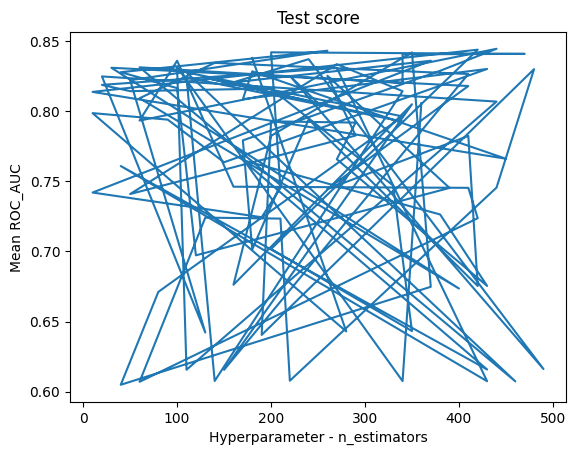

In [99]:
plt.plot(results['param_n_estimators'],results['mean_test_score']);
plt.grid();
plt.xlabel('Hyperparameter - n_estimators');
plt.ylabel('Mean ROC_AUC');
plt.title('Test score'); 
plt.grid();

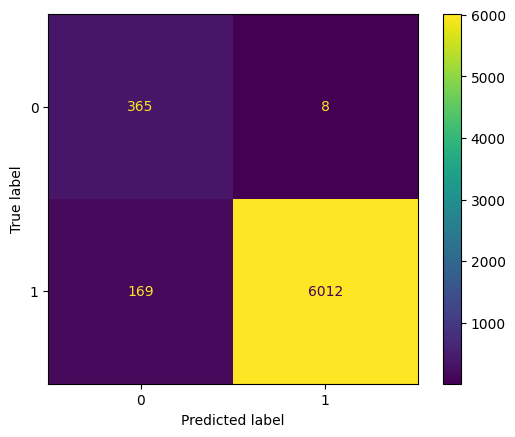

In [100]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=best_model.classes_)
disp.plot()
plt.show()

Random Forest on OHE

In [101]:
param_grid = {
    'n_estimators': np.arange(10, 500, 10),
    'max_depth': np.arange(1, 20),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rf = RandomForestClassifier(random_state=random_state, class_weight='balanced', n_jobs=-1)
clf = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=100, cv=cv, verbose=verbose, random_state=random_state, n_jobs=-1, scoring=scoring)
best_model=clf.fit(train_ohe,y_true)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [102]:
best_model.best_params_

{'n_estimators': 340,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_depth': 19,
 'bootstrap': False}

In [103]:
n_estimators=best_model.best_params_['n_estimators']
min_samples_split=best_model.best_params_['min_samples_split']
min_samples_leaf=best_model.best_params_['min_samples_leaf']
max_depth=best_model.best_params_['max_depth']
bootstrap=best_model.best_params_['bootstrap']

In [114]:
model=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth, min_samples_split=min_samples_split, random_state=random_state,class_weight='balanced',n_jobs=-1)
model.fit(train_ohe,y_true)

RandomForestClassifier(class_weight='balanced', max_depth=19,
                       min_samples_split=10, n_estimators=340, n_jobs=-1,
                       random_state=42)

In [115]:
y_pred=model.predict(train_ohe)
test_acc_rf_ohe=accuracy_score(y_true,y_pred)*100
auc_rf_ohe = roc_auc_score(y_true, y_pred)
test_acc_rf_ohe,auc_rf_ohe

(88.7698739662486, 0.751154775758508)

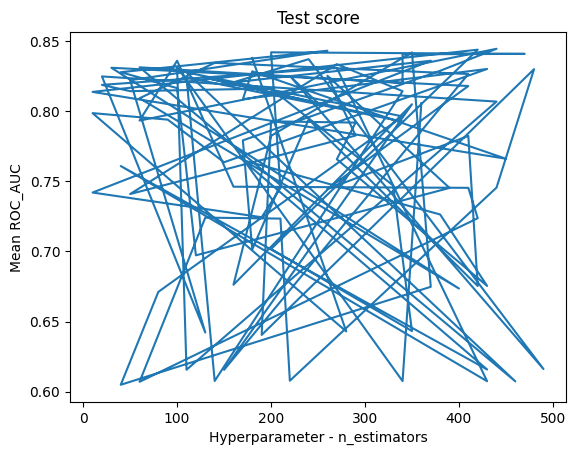

In [109]:
plt.plot(results['param_n_estimators'],results['mean_test_score']);
plt.grid();
plt.xlabel('Hyperparameter - n_estimators');
plt.ylabel('Mean ROC_AUC');
plt.title('Test score'); 
plt.grid();

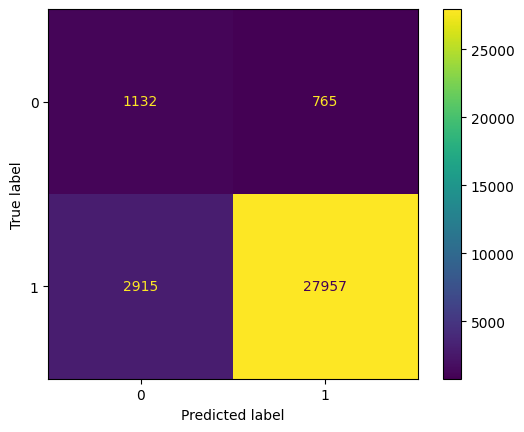

In [111]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=best_model.classes_)
disp.plot()
plt.show()

In [116]:
from prettytable import PrettyTable
x = PrettyTable(['Model', 'Feature', 'Accuracy', 'ROC_AUC'])
x.add_row(['Random Forest', '-', round(test_acc_rf,5), round(auc_rf,5)])
x.add_row(['Random Forest','ohe', round(test_acc_rf_ohe,5), round(auc_rf_ohe,5)])
print(x)

+---------------+---------+----------+---------+
|     Model     | Feature | Accuracy | ROC_AUC |
+---------------+---------+----------+---------+
| Random Forest |    -    | 97.23833 | 0.97528 |
| Random Forest |   ohe   | 88.76987 | 0.75115 |
+---------------+---------+----------+---------+


Comparison

In [128]:
x = PrettyTable()
x.field_names = ['Model', 'Feature', 'Accuracy', 'ROC_AUC']
x.add_row(['KNeighborsClassifier', '-', round(test_acc_knn,5), round(auc_knn,5)])
x.add_row(['KNeighborsClassifier','OHE', round(test_acc_knn_ohe,5), round(auc_knn_ohe,6)])
# x.add_row(["-"*4])
x.add_row(['-' * len(x.field_names)] * len(x.field_names)) 
x.add_row(['Logistic Regression', '-', round(test_acc_knn,5), round(auc_lr,5)])
x.add_row(['Logistic Regression','OHE', round(test_acc_lr_ohe,5), round(auc_lr_ohe,5)])
x.add_row(['-' * len(x.field_names)] * len(x.field_names)) 
x.add_row(['Decision Tree', '-', round(test_acc_dt,5), round(auc_dt,5)])
x.add_row(['Decision Tree','OHE', round(test_acc_dt_ohe,5), round(auc_dt_ohe,5)])
x.add_row(['-' * len(x.field_names)] * len(x.field_names)) 
x.add_row(['Random Forest', '-', round(test_acc_rf,5), round(auc_rf,5)])
x.add_row(['Random Forest','OHE', round(test_acc_rf_ohe,5), round(auc_rf_ohe,5)])
print(x)

+----------------------+---------+----------+----------+
|        Model         | Feature | Accuracy | ROC_AUC  |
+----------------------+---------+----------+----------+
| KNeighborsClassifier |    -    | 94.32408 | 0.50134  |
| KNeighborsClassifier |   OHE   | 94.51921 | 0.541711 |
|         ----         |   ----  |   ----   |   ----   |
| Logistic Regression  |    -    | 94.32408 | 0.97561  |
| Logistic Regression  |   OHE   | 88.76987 | 0.75115  |
|         ----         |   ----  |   ----   |   ----   |
|    Decision Tree     |    -    | 93.5917  | 0.62342  |
|    Decision Tree     |   OHE   | 97.1773  | 0.86285  |
|         ----         |   ----  |   ----   |   ----   |
|    Random Forest     |    -    | 97.23833 | 0.97528  |
|    Random Forest     |   OHE   | 88.76987 | 0.75115  |
+----------------------+---------+----------+----------+


From The Above table Decision Tree(OHE) and random Forest(raw data) has highest accuracy 
And Logistic Regression(raw data) and Random Forest(OHE) has highest Aread under ROC.

In [131]:
# x = PrettyTable()
# x.field_names = ['Model', 'Feature', 'Accuracy', 'ROC_AUC']
# x.add_row(['KNeighborsClassifier', '-', round(test_acc_knn,5), round(auc_knn,5)])
# x.add_row(['KNeighborsClassifier','OHE', round(test_acc_knn_ohe,5), round(auc_knn_ohe,6)])
# x.add_row(['Logistic Regression', '-', round(test_acc_knn,5), round(auc_lr,5)])
# x.add_row(['Logistic Regression','OHE', round(test_acc_lr_ohe,5), round(auc_lr_ohe,5)])
# x.add_row(['Decision Tree', '-', round(test_acc_dt,5), round(auc_dt,5)])
# x.add_row(['Decision Tree','OHE', round(test_acc_dt_ohe,5), round(auc_dt_ohe,5)])
# x.add_row(['Random Forest', '-', round(test_acc_rf,5), round(auc_rf,5)])
# x.add_row(['Random Forest','OHE', round(test_acc_rf_ohe,5), round(auc_rf_ohe,5)])

# # Find the maximum values of Accuracy and ROC_AUC
# max_acc = max(x, key=lambda row: row[2] if isinstance(row[2], float) else float('-inf'))[2]
# max_roc_auc = max(x, key=lambda row: row[3] if isinstance(row[3], float) else float('-inf'))[3]

# # Iterate over the rows and highlight the maximum values
# for row in x:
#     if row[2] == max_acc:
#         row_str = x.get_string(fields=[0,1,2,3], start=0, end=1)
#         row_str = row_str.replace(str(max_acc), f"\033[1m{max_acc}\033[0m")
#         print(row_str)
#     elif row[3] == max_roc_auc:
#         row_str = x.get_string(fields=[0,1,2,3], start=0, end=1)
#         row_str = row_str.replace(str(max_roc_auc), f"\033[1m{max_roc_auc}\033[0m")
#         print(row_str)
#     else:
#         print(row)
